In [54]:
import pandas as pd
from utils.constants import Paths

Pre-process for handling

In [55]:
df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")

In [56]:
df["year_month"] = df["date_created"].dt.to_period("M")

In [57]:
df = df[df["population_density"] > 100]

In [58]:
from shapely.ops import unary_union
from shapely.wkt import loads

In [59]:
# use wkt load to convert the string to a shapely object
df["geometry"] = df["geometry"].apply(loads)

Define columns we want to use for causality analysis (socio-economic factors)

In [60]:
describe_columns = [
    "median_age",
    "hispanic_pct",
    "white_nh_pct",
    "black_nh_pct",
    "asian_nh_pct",
    "average_hh_size",
    "less_than_hs_pct",
    "hs_pct",
    "some_college_pct",
    "associate_degree_pct",
    "bachelors_or_higher_pct",
    "median_household_income",
]

Group df by street and month (borough, neighborhood are just carried over because we'll need them later)

Along with grouping we aggregate all the socioeconomic factors, for most we just average them, here are the special cases:
- `geometry`: for this we want to find the centroid of the data points on the street
- `date_created`: this is no longer date created when aggregated, instead it becomes the number of reports in each group

In [61]:
grouped_df = (
    df.groupby(["borough","neighborhood","street", "year_month"])
    .agg(
        {
            "date_created": "size",
            "rating": "mean",
            "population_density": "mean",
            "street_length": "mean",
            "geometry": lambda x: unary_union(x).centroid,
            "median_age": "mean",
            "hispanic_pct": "mean",
            "white_nh_pct": "mean",
            "black_nh_pct": "mean",
            "asian_nh_pct": "mean",
            "average_hh_size": "mean",
            "less_than_hs_pct": "mean",
            "hs_pct": "mean",
            "some_college_pct": "mean",
            "associate_degree_pct": "mean",
            "bachelors_or_higher_pct": "mean",
            "median_household_income": "mean",
            }
    )
    .reset_index()
)
grouped_df.rename(columns={"date_created": "report_count"}, inplace=True)

# this formula is subject to change
# grouped_df['reporting_ratio'] = grouped_df['report_count'] / grouped_df['rating']

Here we are finding the reporting ratio, which is the number of reports per group (group = potholes on street/month) normalized by the popilation density and street length

In [62]:
grouped_df["reporting_ratio"] = grouped_df["report_count"] / (
    grouped_df["population_density"] * grouped_df["street_length"]
)

In [63]:
# get 95% percentile to eliminate extreme outliers
reporting_ratio_threshold = grouped_df["reporting_ratio"].quantile(0.99)

grouped_df = grouped_df[grouped_df["reporting_ratio"] < reporting_ratio_threshold]

In [64]:
grouped_df["normalized_reporting_ratio"] = 1 + 9 * (
    (grouped_df["reporting_ratio"] - grouped_df["reporting_ratio"].min())
    / (grouped_df["reporting_ratio"].max() - grouped_df["reporting_ratio"].min())
)

This is the distribution of the reporting ratio (mapped to 0-10 range) 

<Axes: ylabel='Frequency'>

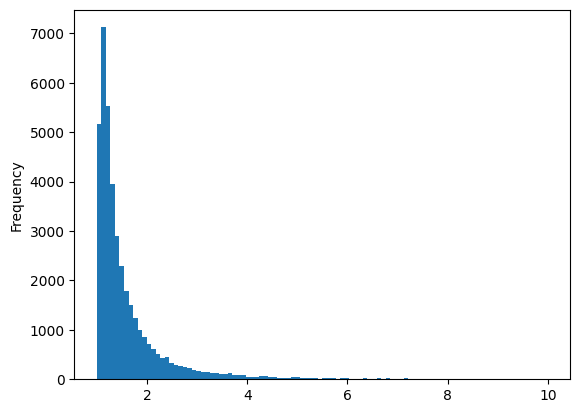

In [65]:
grouped_df['normalized_reporting_ratio'].plot.hist(bins=100)

In [66]:
import matplotlib.pyplot as plt

In [67]:
average_reporting_ratio = grouped_df["normalized_reporting_ratio"].mean()

In [68]:
import geopandas as gpd
import matplotlib.colors as colors
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

We convert the grouped dataframe into a GeoDataFrame so that we can perform spatial operations on it. Namely, we want to visualize the spatial distribution of the reporting ratio

In [69]:
grouped_gdf = gpd.GeoDataFrame(grouped_df, geometry="geometry", crs="3857")

This metric is over/underreporting ratio, we can use the ground truth street pavement rating to find this. Conceptually, if this difference is near 0, it means the reports are *in-line* with the actual condition of the sidewalk.

If the difference is >0 it could suggest overreporting, and same logic for <0 and underreporting

In [70]:
grouped_gdf['reporting_difference'] = grouped_gdf['normalized_reporting_ratio'] - grouped_gdf['rating']

In [71]:
# range of differences
grouped_gdf['reporting_difference'].max(), grouped_gdf['reporting_difference'].min()

(8.472255058740814, -8.848176541845774)

Here we are visualizing the spatial distribution of this over/underreporting rate

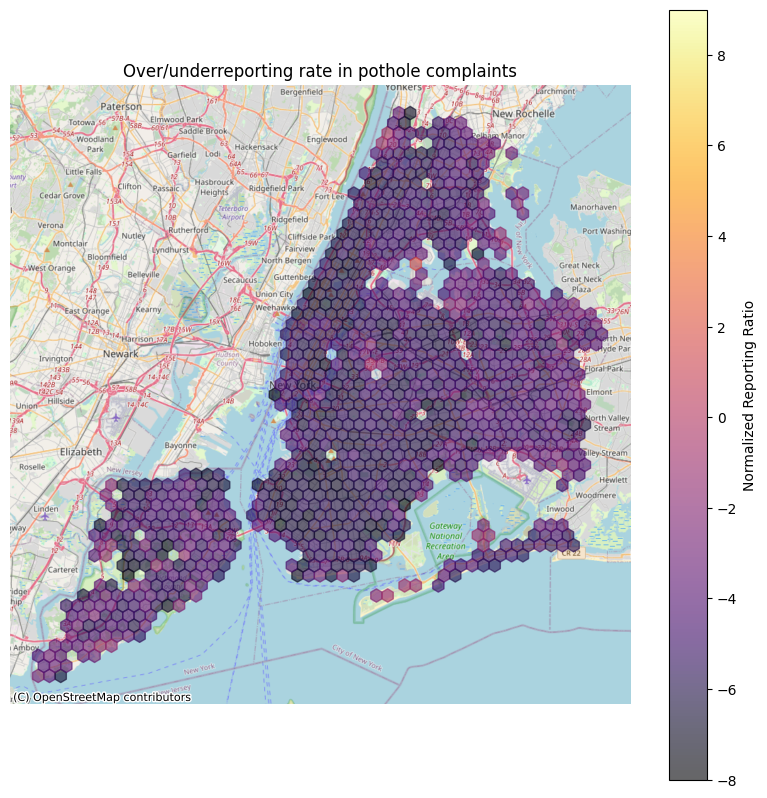

In [72]:
norm = colors.Normalize(vmin=-8, vmax=9)

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = grouped_gdf.geometry.x
y = grouped_gdf.geometry.y

hb = ax.hexbin(x, y, C=grouped_gdf['reporting_difference'], gridsize=50, reduce_C_function=np.mean, cmap='inferno', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Normalized Reporting Ratio')

# Add the basemap
ctx.add_basemap(ax, crs=grouped_gdf.crs.to_string(), source=tile_provider)

plt.title('Over/underreporting rate in pothole complaints')
plt.axis('off')
plt.show()

In [73]:
# remove null values in describe_columns
grouped_gdf = grouped_gdf.dropna(subset=describe_columns)

In [74]:
import seaborn as sns

This is a correlation analysis, showing the correlation between the socioeconomic factors and these two new metrics.

Red values indicate higher positive correlation

Blue values indicate higher negative correlation

White values indicate no correlation

<Axes: >

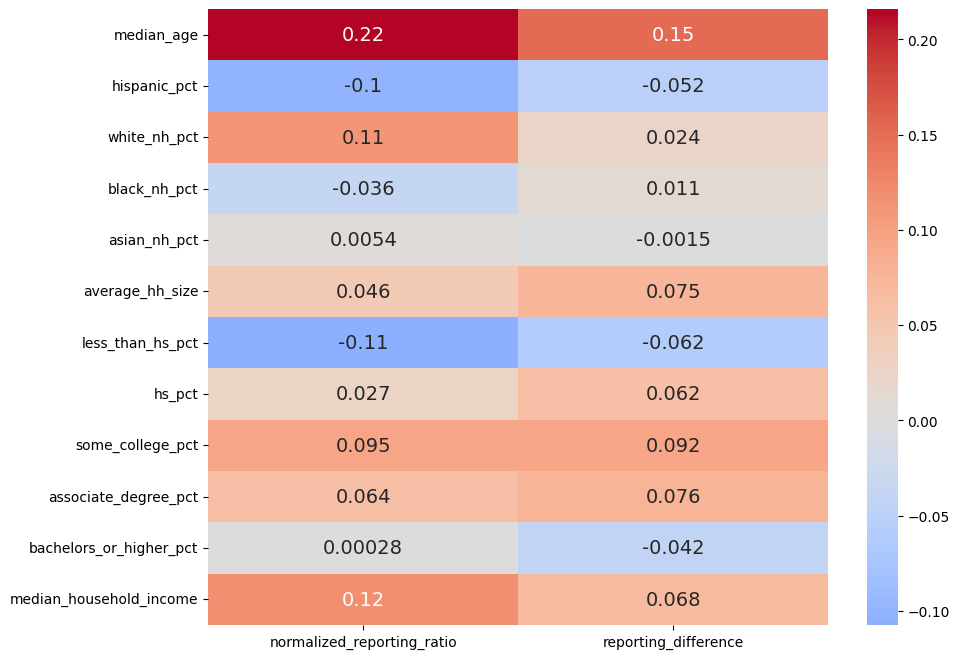

In [75]:
selected_cols = describe_columns + ['normalized_reporting_ratio','reporting_difference'] 
corr = grouped_gdf[selected_cols].corr() 
corr = corr.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns] 
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr.T, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 14})

This is just a visualization of the database schema

In [76]:
from tabulate import tabulate

In [77]:
copy = grouped_gdf.copy()

In [78]:
# Copy the DataFrame to avoid changing the original data
df_copy = copy.copy()

# Truncate the 'neighborhood' column
df_copy['neighborhood'] = df_copy['neighborhood'].apply(lambda x: (x[:10] + '..') if len(x) > 10 else x)

# Print the table
print(tabulate(df_copy.sort_values(by="normalized_reporting_ratio",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+---------------+----------------+---------------------------------------------------+--------------+----------------+----------+----------------------+-----------------+-----------------------------------------------+--------------+----------------+----------------+----------------+----------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-------------------+------------------------------+------------------------+
| borough       | neighborhood   | street                                            | year_month   |   report_count |   rating |   population_density |   street_length | geometry                                      |   median_age |   hispanic_pct |   white_nh_pct |   black_nh_pct |   asian_nh_pct |   average_hh_size |   less_than_hs_pct |   hs_pct |   some_college_pct |   associate_degree_pct |   bachelors_or_higher_pct |   median_household_income |   reporting_

This is the same correlation analysis as before but with 3 different correlation methods:
* Pearson
* Kendall
* Spearman

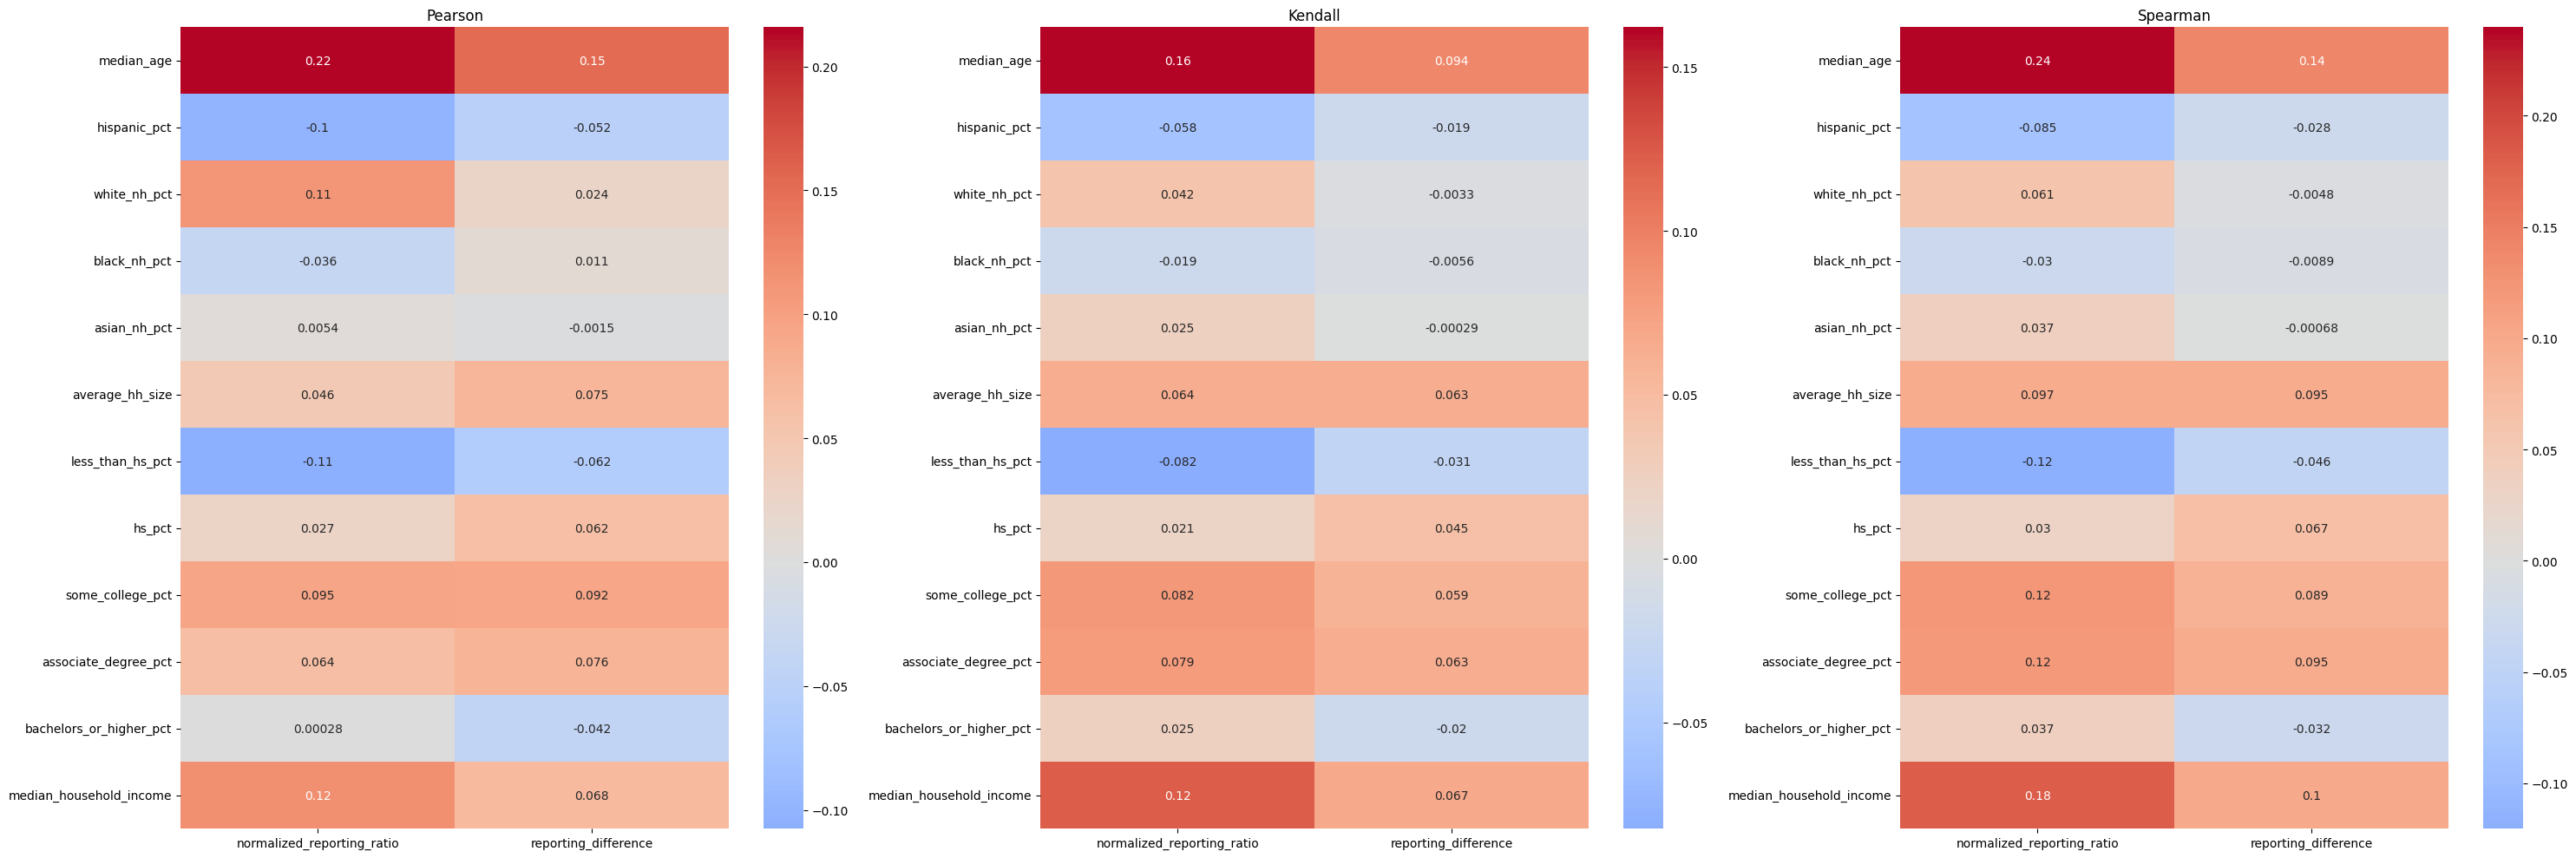

In [79]:
fig, axs = plt.subplots(ncols=3, figsize=(30, 10))

# Pearson correlation
corr_pearson = grouped_gdf[selected_cols].corr(method='pearson')
corr_pearson = corr_pearson.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_pearson.T, annot=True, cmap='coolwarm', center=0, ax=axs[0])
axs[0].set_title('Pearson')

# Kendall correlation
corr_kendall = grouped_gdf[selected_cols].corr(method='kendall')
corr_kendall = corr_kendall.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_kendall.T, annot=True, cmap='coolwarm', center=0, ax=axs[1])
axs[1].set_title('Kendall')

# Spearman correlation
corr_spearman = grouped_gdf[selected_cols].corr(method='spearman')
corr_spearman = corr_spearman.loc[['normalized_reporting_ratio','reporting_difference'],describe_columns]
sns.heatmap(corr_spearman.T, annot=True, cmap='coolwarm', center=0, ax=axs[2])
axs[2].set_title('Spearman')

plt.tight_layout()
plt.show()

In [80]:
X = grouped_gdf[describe_columns]
y = grouped_gdf['reporting_difference']

In [81]:
pd.set_option('display.float_format', '{:.10e}'.format)

Now to display the p-values of the correlation analysis, these indicate the statistical significance of our correlation coefficients

In [82]:
from scipy.stats import pearsonr, kendalltau, spearmanr

# Create a DataFrame to store the p-values
p_values = pd.DataFrame(index=describe_columns, 
                        columns=['Pearson', 'Kendall', 'Spearman'])

# Calculate the p-values
for column in describe_columns:
    _, p_value_pearson = pearsonr(X[column], y)
    _, p_value_kendall = kendalltau(X[column], y)
    _, p_value_spearman = spearmanr(X[column], y)

    
    p_values.loc[column, 'Pearson'] = p_value_pearson
    p_values.loc[column, 'Kendall'] = p_value_kendall
    p_values.loc[column, 'Spearman'] = p_value_spearman

# Display the p-values
p_values

,Pearson,Kendall,Spearman
median_age,2.0385534962e-202,1.7339928625e-172,5.4956375783e-173
hispanic_pct,9.7175136358e-25,2.8770154465e-08,4.1482567110e-08
white_nh_pct,1.0819224032e-06,3.2508361535e-01,3.3748539171e-01
black_nh_pct,2.7467595398e-02,9.6672690296e-02,7.7880246575e-02
asian_nh_pct,7.6392186361e-01,9.3110528047e-01,8.9167078495e-01
average_hh_size,1.3130221739e-50,9.7171731535e-80,1.6790626236e-80
less_than_hs_pct,9.7870327902e-35,8.2243328202e-21,7.0785264068e-20
hs_pct,2.0521977025e-35,2.6212929651e-41,3.1145394827e-41
some_college_pct,2.1974654986e-75,2.4089787694e-68,8.3003163024e-70
associate_degree_pct,2.7608144556e-52,2.3984922612e-79,9.5858507620e-81


The next few visualizations are miscellaneous and more exploratory

Visualize relationship between reporting ratio and ground truth street condition

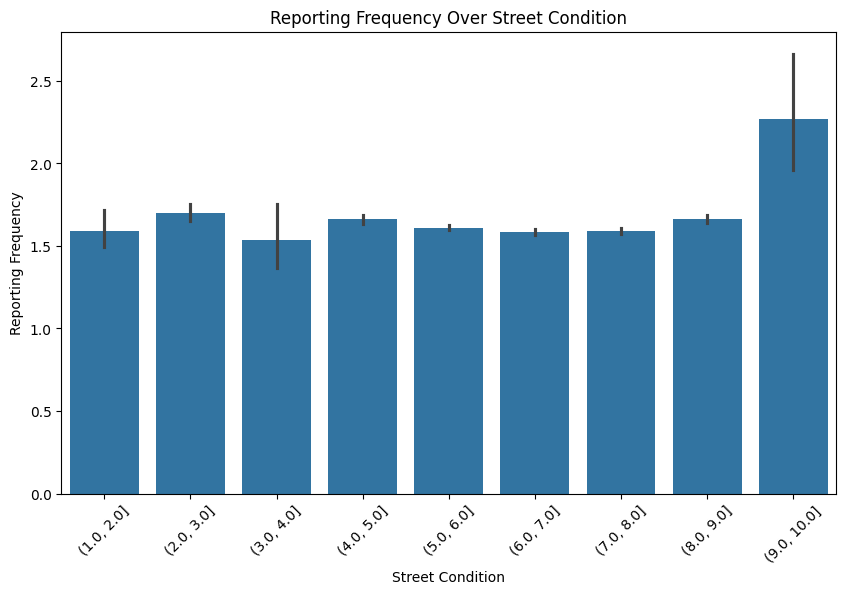

In [84]:
bins = np.linspace(grouped_gdf['rating'].min(), grouped_gdf['rating'].max(), 10)

# Create a new column for the binned street condition
grouped_gdf['binned_street_condition'] = pd.cut(grouped_gdf['rating'], bins)

# Plot the reporting frequency over the binned street condition
plt.figure(figsize=(10, 6))
sns.barplot(x='binned_street_condition', y='normalized_reporting_ratio', data=grouped_gdf)
plt.title('Reporting Frequency Over Street Condition')
plt.xlabel('Street Condition')
plt.ylabel('Reporting Frequency')
plt.xticks(rotation=45)
plt.show()

In [85]:
borough_demographics = grouped_gdf.groupby('borough').agg({
    "median_age": "mean",
    "hispanic_pct": "mean",
    "white_nh_pct": "mean",
    "black_nh_pct": "mean",
    "asian_nh_pct": "mean",
    "average_hh_size": "mean",
    "less_than_hs_pct": "mean",
    "hs_pct": "mean",
    "some_college_pct": "mean",
    "associate_degree_pct": "mean",
    "bachelors_or_higher_pct": "mean",
    "median_household_income": "mean",
})

In [92]:
# visualization of demographics across all boroughs
borough_demographics

,median_age,hispanic_pct,white_nh_pct,black_nh_pct,asian_nh_pct,average_hh_size,less_than_hs_pct,hs_pct,some_college_pct,associate_degree_pct,bachelors_or_higher_pct,median_household_income
borough,,,,,,,,,,,,
Bronx,37.503921,49.523620,14.883317,27.023502,5.028956,2.684615,22.643400,27.043798,16.465909,8.104517,25.743377,60758.490473
Brooklyn,35.858442,19.935612,36.054926,25.991334,12.438061,2.730535,15.739351,24.937390,12.511559,6.183091,40.626840,86967.287815
Manhattan,37.771129,21.142130,49.751707,9.735886,14.691788,1.961065,9.900126,10.710123,8.954709,3.208580,67.228338,126425.155904
Queens,39.914271,24.878791,24.455407,18.099473,25.907853,2.918020,16.751944,26.189345,14.593560,7.606504,34.854485,89606.669452
Staten Island,41.508574,17.682830,61.053933,6.718415,11.594977,2.820806,10.729825,29.853226,15.800882,7.646280,35.954819,104853.663850


In [86]:
pd.reset_option('display.float_format')

Here we discretize the reporting ratio, to plot its relationship with each demographic data group (education, race, other)

In [87]:
bins = np.linspace(grouped_df['normalized_reporting_ratio'].min(), grouped_df['normalized_reporting_ratio'].max(), 11)
labels = range(1, 11)

# Create a new column for the discrete rating
grouped_df['discrete_normalized_reporting_ratio'] = pd.cut(grouped_df['normalized_reporting_ratio'], bins=bins, labels=labels)

In [88]:
groups = {
    "education_columns": ["less_than_hs_pct", "hs_pct", "some_college_pct", "associate_degree_pct", "bachelors_or_higher_pct"],
    "race_columns": ["hispanic_pct", "white_nh_pct", "black_nh_pct", "asian_nh_pct"],
    "other_columns": ["median_age", "average_hh_size", "median_household_income"]
}

for group_name, columns in groups.items():
    plt.figure(figsize=(10, 6))
    for column in columns:
        mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
        std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()
        plt.errorbar(mean_values.index, mean_values.values, yerr=std_values.values, marker='o', capsize=5, label=column)
    plt.title(f'Mean Values Across Discrete Street Ratings for {group_name}')
    plt.xlabel('Discrete Street Rating')
    plt.ylabel('Mean Values')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.savefig(f'{group_name}.png')
    plt.close()

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_82127/1678577568.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].mean()
/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_82127/1678577568.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = grouped_df.groupby('discrete_normalized_reporting_ratio')[column].std()


Here we attempt to fit the data with a regression model (should be moved to its own notebook)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Define independent variables (predictors) and dependent variable (response)
X = grouped_gdf[describe_columns]
y = grouped_gdf['reporting_difference']

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a LinearRegression object
regressor = LinearRegression()

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Print the coefficients
print('Coefficients: \n', regressor.coef_)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred))

Coefficients: 
 [ 5.62225873e-02 -1.75872293e-02 -2.13582295e-02 -1.81440955e-02
 -1.34079475e-02  5.32083215e-01 -1.11165857e+00 -1.08168791e+00
 -1.05443878e+00 -1.04910829e+00 -1.09407493e+00  9.14627181e-06]
Mean squared error: 7.27
Coefficient of determination: 0.06


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred_rf))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred_rf))

Mean squared error: 5.37
Coefficient of determination: 0.31


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a GradientBoostingRegressor object
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=0)

# Fit the model
gb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test)

# Print the mean squared error
print('Mean squared error: %.2f'
    % metrics.mean_squared_error(y_test, y_pred_gb))

# Print the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % metrics.r2_score(y_test, y_pred_gb))

Mean squared error: 6.33
Coefficient of determination: 0.18


In [93]:
grouped_gdf.columns

Index(['borough', 'neighborhood', 'street', 'year_month', 'report_count',
       'rating', 'population_density', 'street_length', 'geometry',
       'median_age', 'hispanic_pct', 'white_nh_pct', 'black_nh_pct',
       'asian_nh_pct', 'average_hh_size', 'less_than_hs_pct', 'hs_pct',
       'some_college_pct', 'associate_degree_pct', 'bachelors_or_higher_pct',
       'median_household_income', 'reporting_ratio',
       'normalized_reporting_ratio', 'reporting_difference',
       'binned_street_condition'],
      dtype='object')